
In this notebook we train the ensemble of ResNet50 and LSTM model on DFDC training dataset.

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install face_recognition library
!pip3 install face_recognition

     |████████████████████████████████| 100.1 MB 16 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=65b9a1ddee128e2d040bffff0eba3d9baa332656042ac19c6da92de1db0a2192
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
# import required libraries
import json
import glob
import numpy as np
import cv2
import copy
import random

# provide the path to the folder containing the preprocessed train dataset files
video_files =  glob.glob('/content/drive/MyDrive/Deepfake/data/train/faces_train_16k/*.mp4')

random.shuffle(video_files)

# counting the number of frames in the videos
# Only videos having framecount greater then 150 in total are kept.
# videos lesser than 150 frames are too short to be processed upon.
# therefore the videos whith less then 150 frames are deleted.

frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

print("Training Videos: ")
print("Total no of video: " , len(frame_count))
print('Average frame per video:', np.mean(frame_count))

Training Videos: 
Total no of video:  15840
Average frame per video: 147.6419191919192


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import face_recognition

class video_dataset(Dataset):
    """
  this class accepts preprocessed video dataset as input, extracts the faces from
  each of the video, recognizes the faces and stacks the extracted frames together
  """
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["filename"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames, label

    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
              
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
def number_of_real_and_fake_videos(data_list):
"""
Function to count the number of real and fake videos
"""
  lab = pd.read_csv('/content/drive/MyDrive/Deepfake/data/train/label11.csv')

  fake = 0
  real = 0

  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["filename"] == temp_video].index.values[0]),1]

    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real, fake

train :  8013
test :  7950
TRAIN:  Real: 3945  Fake: 4068


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:  Real: 4024  Fake: 3926


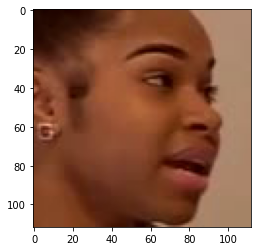

In [ ]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# read the training labels into labels dataframe
labels = pd.read_csv('/content/drive/MyDrive/Deepfake/data/train/label11.csv')

# split the training dataset into train and val
train_videos = video_files[:int(0.502*len(video_files))]
valid_videos = video_files[int(0.502*len(video_files)):]

print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# tranform both train and val datasets

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)

# load the data into dataloader and create batches and num of workers
train_loader = DataLoader(train_data, batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data, batch_size = 4,shuffle = True,num_workers = 4)

image,label = train_data[0]
im_plot(image[0,:,:,:])

In [ ]:
from torch import nn
from torchvision import models
class Model(nn.Module):
  """
  Base class for all neural network modules.
  Ensemble model of resnet and lstm is built 
  We use of a 2048-wide LSTM unit with 0.4 dropout.
  LSTM model takes a sequence of 2048 dimensional ImageNet feature vectors.
  The LSTM is followed by a 512 fully-connected layer
  """
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnet50(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
# create a resnet50 model
model = Model(2).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys

# train and validate the model and caluclate loss, accuracy using AverageMeter()
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
        # save the trained model as a checkpoint
    torch.save(model.state_dict(),'/content/drive/MyDrive/Deepfake/data/checkpoints/resnet50_16k.pt')
    return losses.avg,accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

class AverageMeter(object):
   
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
import seaborn as sn
# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  """ Plot train and validation loss"""
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  """ Plot train and validation accuracy"""
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1/20] [Batch 2003 / 2004] [Loss: 0.521221, Acc: 73.19%]Testing
[Batch 1987 / 1988]  [Loss: 0.262522, Acc: 89.94%]
Accuracy 89.937106918239
[Epoch 2/20] [Batch 2003 / 2004] [Loss: 0.414167, Acc: 80.23%]Testing
[Batch 1987 / 1988]  [Loss: 0.219563, Acc: 92.08%]
Accuracy 92.0754716981132
[Epoch 3/20] [Batch 2003 / 2004] [Loss: 0.348130, Acc: 83.24%]Testing
[Batch 1987 / 1988]  [Loss: 0.187484, Acc: 93.41%]
Accuracy 93.40880503144655
[Epoch 4/20] [Batch 2003 / 2004] [Loss: 0.303716, Acc: 85.54%]Testing
[Batch 1987 / 1988]  [Loss: 0.209872, Acc: 92.74%]
Accuracy 92.74213836477988
[Epoch 5/20] [Batch 2003 / 2004] [Loss: 0.254747, Acc: 87.02%]Testing
[Batch 1987 / 1988]  [Loss: 0.209462, Acc: 93.12%]
Accuracy 93.11949685534591
[Epoch 6/20] [Batch 2003 / 2004] [Loss: 0.222276, Acc: 88.43%]Testing
[Batch 1987 / 1988]  [Loss: 0.207641, Acc: 93.48%]
Accuracy 93.48427672955975
[Epoch 7/20] [Batch 2003 / 2004] [Loss: 0.207459, Acc: 89.16%]Testing
[Batch 1987 / 1988]  [Loss: 0.206686, Acc: 94

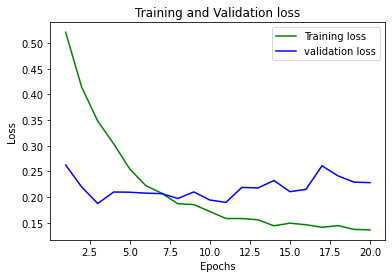

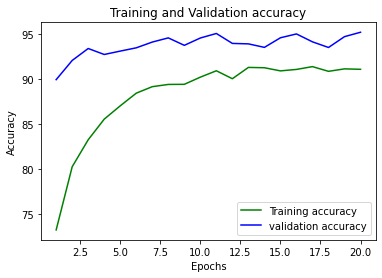

[[3760  166]
 [ 214 3810]]
True positive =  3760
False positive =  166
False negative =  214
True negative =  3810




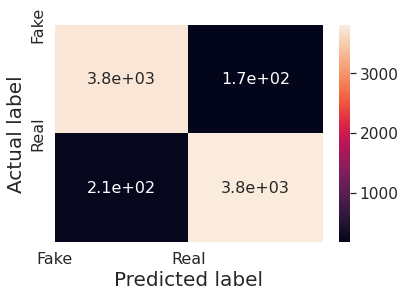

Calculated Accuracy 95.22012578616352


In [ ]:
from sklearn.metrics import confusion_matrix
lr = 1e-5 #0.001
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
    
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)